# Modèles statistiques multivariés

La transformée de Fourier nous permet de déceler des saisonnalités cachées dans nos données, et est bien utile pour choisir la saisonnalité d'un modèle SARIMA. 

Cependant, de nombreux phénomènes ont plusieurs saisonnalités et des patterns plus complexes.

Pour reprendre l'exemple de la consommation électrique en Allemagne : 

- saisonnalité journalière (heures pleines vs heures creuses)
- saisonnalité hebdomadaire (weekends vs jours ouvrés)
- saisonnalité annuelle (été vs hiver)
- ...

D'autre part, ces variations peuvent s'expliquer par d'autres facteurs : 
- température
- prix de l'électricité 
- ...

Pour capturer ces variations, on utilise des **modèles multivariés**, c'est-à-dire des modèles qui prennent en compte plusieurs variables.

Typiquement, les données d'entrées ressemblent à ça : 

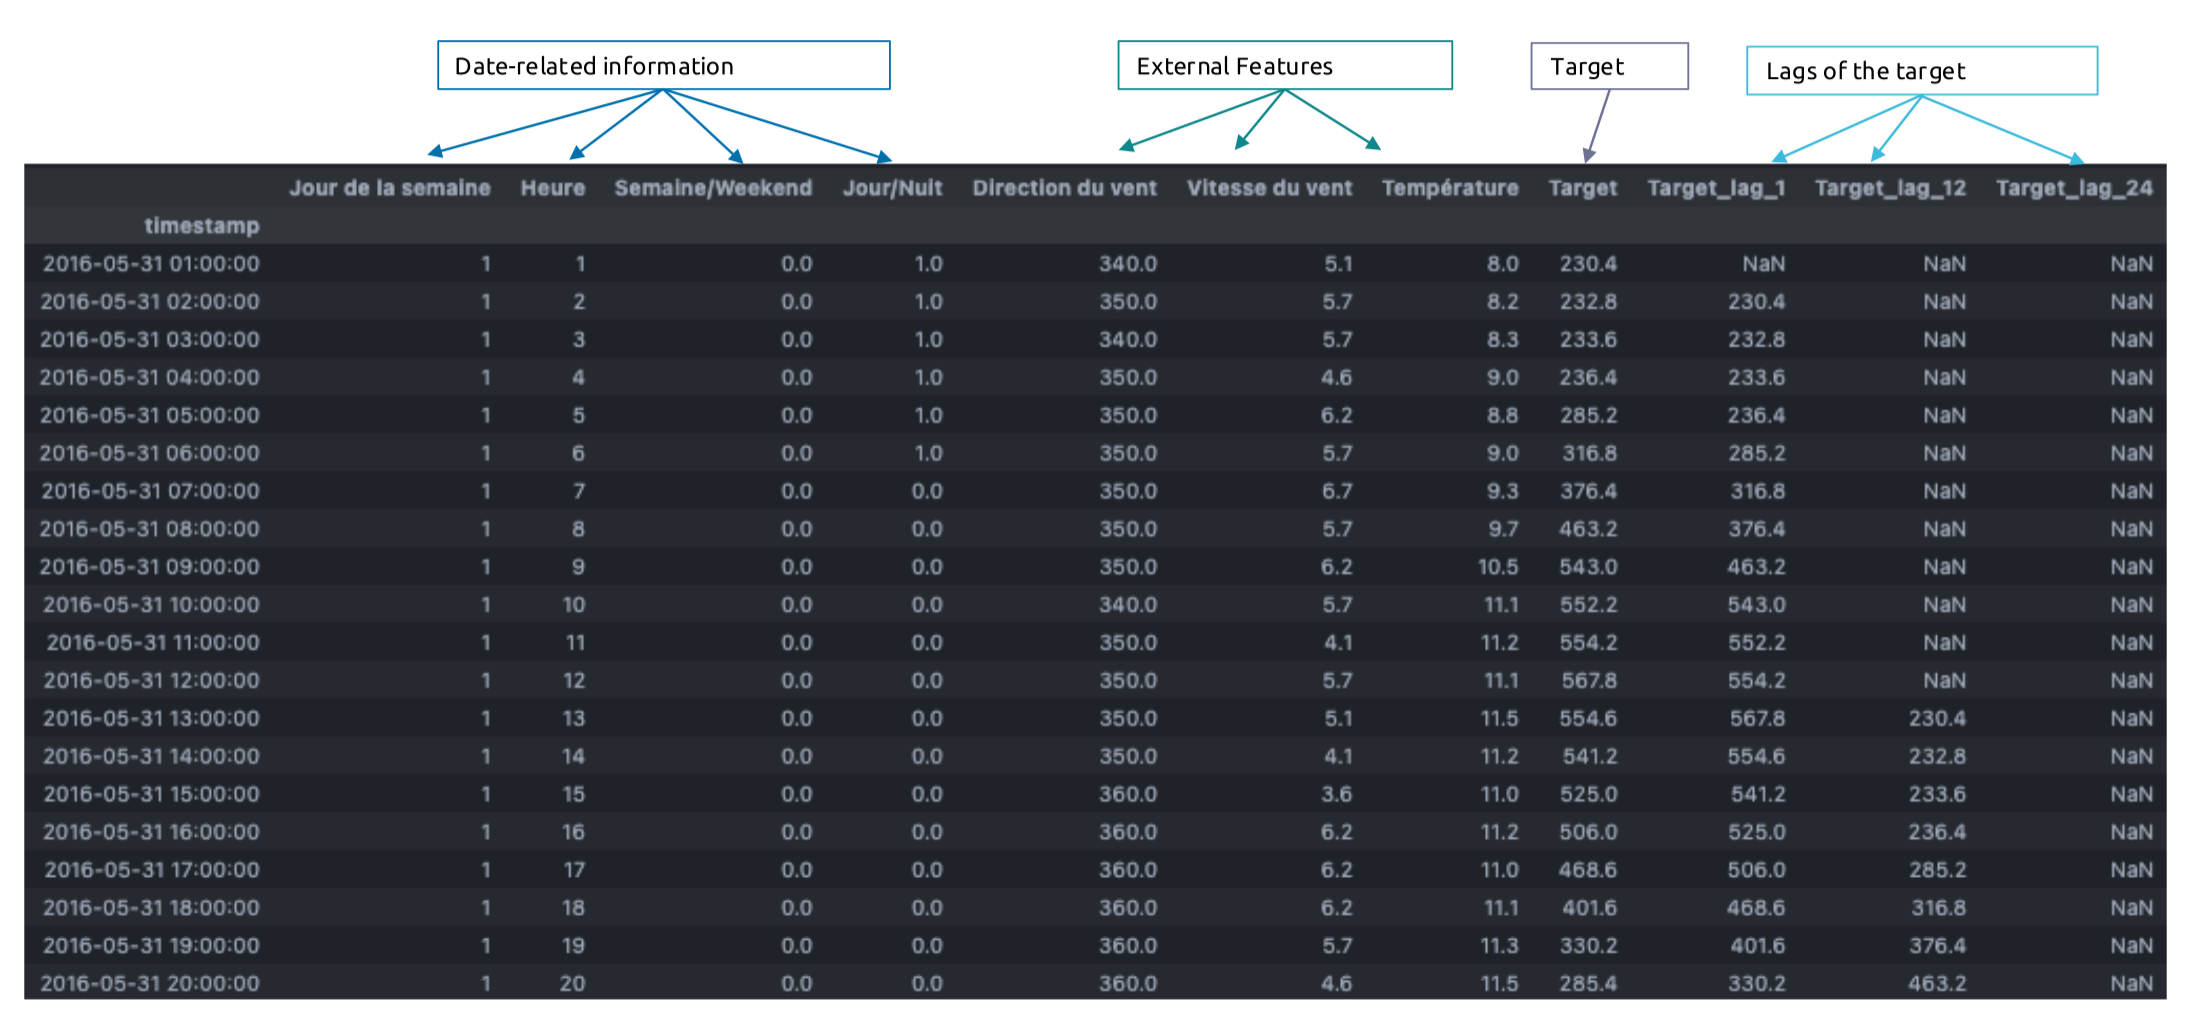

## Modèles multivariés classiques 

Il y a ceux que vous connaissez déjà : 

- Régression Linéaire / Lasso / Ridge / Elasticnet

Les extensions de ceux que vous venez d'apprendre : 

- ARIMA**X** / SARIMA**X** / ARMA**X**

Et ceux que vous verrez bientôt :

- RandomFOrest, XGBoost, Prophet, LTSM ...



## Feature engineering pour les séries temporelles

Classiquement on performe une EDA (plots des moyennes par jour / semaine ..., Transformée de Fourier ...), si l'EDA semble indiquer une relation intéressante, on en fait une feature avec : 

-  `OneHotEncoding` : isweekend / is holidays ...
-  Termes de Fourier
-  statistiques de lag (moyenne / vol glissante, valeurs des lags)
-  Encodage cyclique , voir [docsklearn](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html) 
-  autres encodings (polynomial, interaction ...)

## Modélisation

On peut ensuite suivre le cycle classique de modélisation : 

- choix d'un ou plusieurs modèle 
- grid search des hyperparamètres du modèle, des transformations
- validation du modèle 
- prédiction

## Exercice pratique

### 1. Chargement des données et EDA

In [1]:
import pandas as pd
df = pd.read_csv("data_beijing_cleaned.csv")
df

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date
0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...
43819,8.0,-23,-2.0,1034.0,NW,231.97,0,0,2014-12-31 19:00:00
43820,10.0,-22,-3.0,1034.0,NW,237.78,0,0,2014-12-31 20:00:00
43821,10.0,-22,-3.0,1034.0,NW,242.70,0,0,2014-12-31 21:00:00
43822,8.0,-22,-4.0,1034.0,NW,246.72,0,0,2014-12-31 22:00:00


Convertissez la colonne date en type `datetime` et mettez là en index de la df. 
Spécifiez la fréquence (horaire) de l'index.

In [2]:
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

Affichez la target

<Axes: xlabel='date'>

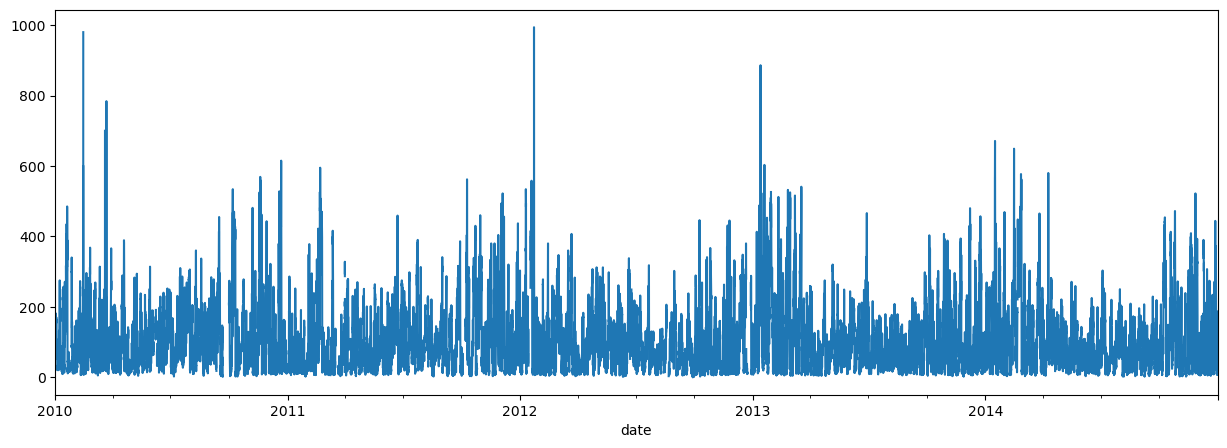

In [3]:
df["pm2.5"].plot(figsize=(15, 5))

Remplacez les valeurs manquantes

In [4]:
df.bfill(inplace=True)

<Axes: xlabel='date'>

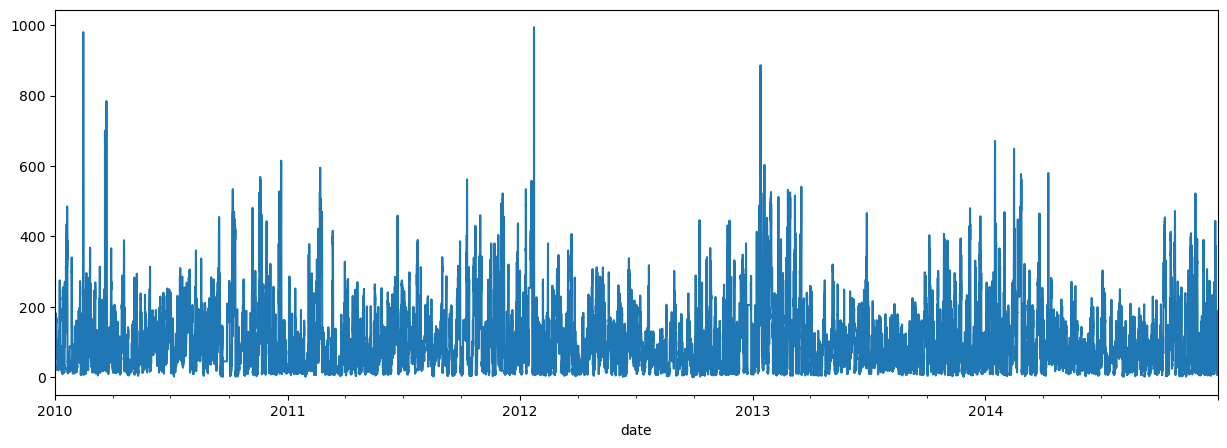

In [5]:
df["pm2.5"].plot(figsize=(15, 5))

La série est elle stationnaire ? 

In [6]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["pm2.5"])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -20.994474481842694
p-value: 0.0


Stabiliser la variance avec une transformation Yeo-Johnson 
> observez comment la série ressemble plus à un processus de type AR / MA

<Axes: xlabel='date'>

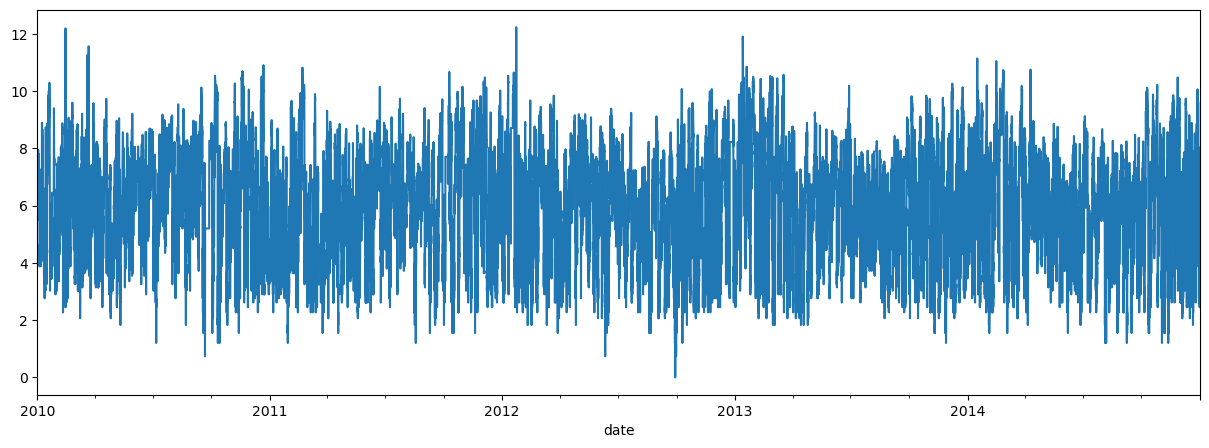

In [7]:
from scipy.stats import yeojohnson

df["pm2.5_transformed"], _ = yeojohnson(df["pm2.5"])

df["pm2.5_transformed"].plot(figsize=(15, 5))

In [8]:
result = adfuller(df["pm2.5_transformed"])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -21.871651047388735
p-value: 0.0


Créez les features suivantes avec pandas: 

- dayofweek
- hour
- month
- season 

[ça peut vous aider de regarder ça](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components)

> attention les saisons ne sont pas les mêmes !

In [9]:
df["dayofweek"] = df.index.day_of_week
df["hour"] = df.index.hour
df["month"] = df.index.month

def get_season_beijing(month):
    if month in [4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    elif month in [9, 10]:
        return "autumn"
    else:
        return "winter"


df["season"] = df["month"].apply(get_season_beijing)


Affichez les tendances par mois et par heure

> je vous propose plusieurs visuels

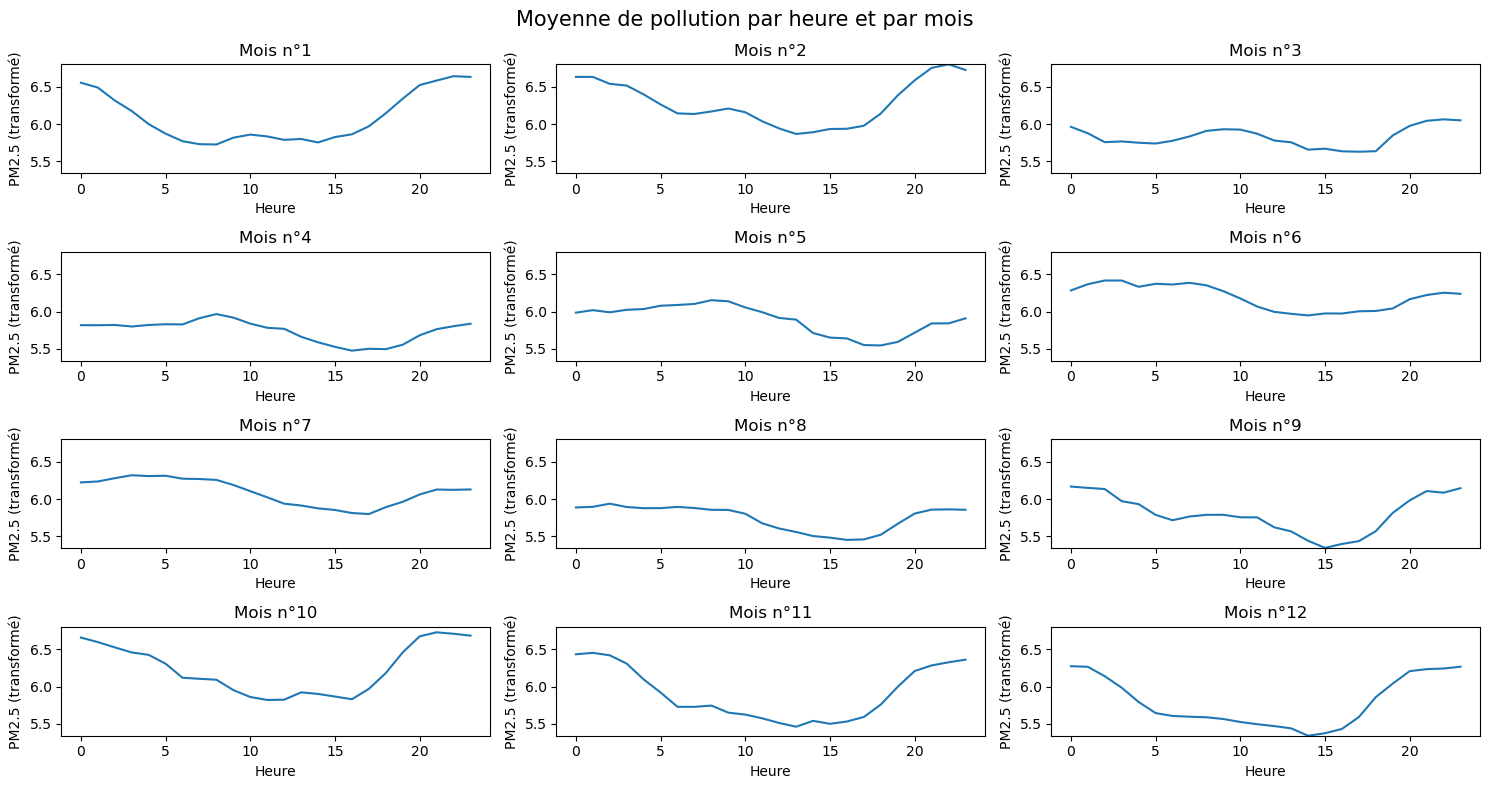

In [10]:
import matplotlib.pyplot as plt

# calcul des moyennes
df_mean = (
    df.groupby(["month", "hour"], as_index=False)["pm2.5_transformed"]
      .mean()
)

fig, axs = plt.subplots(4, 3, figsize=(15, 8))
axs = axs.flatten()

ymin = df_mean["pm2.5_transformed"].min()
ymax = df_mean["pm2.5_transformed"].max()

for ax in axs:
    ax.set_ylim(ymin, ymax)


# pour chaque mois
for i in range(12):
    month_data = df_mean[df_mean["month"] == i + 1]

    axs[i].plot(
        month_data["hour"],
        month_data["pm2.5_transformed"]
    )
    axs[i].set_title(f"Mois n°{i+1}")
    axs[i].set_xlabel("Heure")
    axs[i].set_ylabel("PM2.5 (transformé)")

plt.suptitle("Moyenne de pollution par heure et par mois", fontsize=15)
plt.tight_layout()
plt.show()


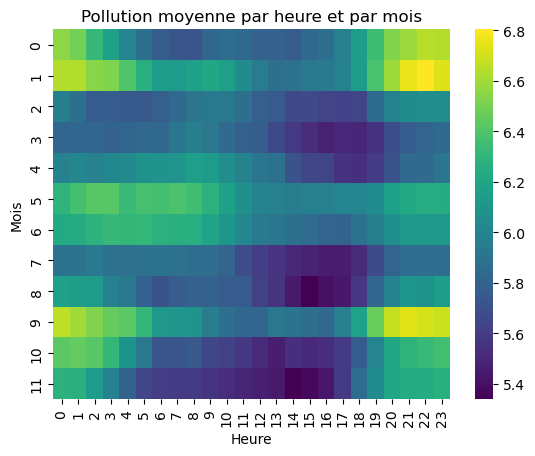

In [11]:
import seaborn as sns

arr = df_mean["pm2.5_transformed"].values.reshape(12, 24)
ax = sns.heatmap(arr, cmap="viridis")
ax.set_title("Pollution moyenne par heure et par mois")
ax.set_xlabel("Heure")
ax.set_ylabel("Mois")
plt.show();

> C'est frappant de voir que les comportements sont très différents selon les mois et les heures
- la pollution est surtout dans la soirée et jusqu'à l'aube
- il y a moins de pollution en mars / avril / mai / aout / septembre
- on pourrait rajouter des termes d'interactions : 19h en mars et 19h en janvier ne sont clairement pas pareils

Est ce qu'il y a de la saisonnalité ? 

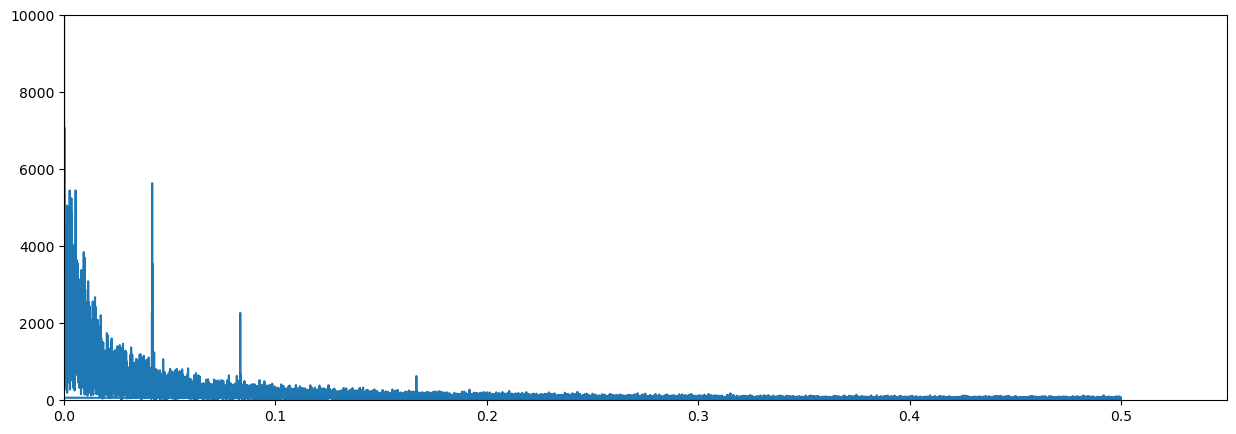

In [12]:
signal = df["pm2.5_transformed"]

# fft 
fft_values = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(fft_values))
magnitude = np.abs(fft_values)

# plot interactif
import plotly
plt.figure(figsize=(15, 5))
plt.plot(frequencies, magnitude)
plt.xlim(0)
plt.ylim(0, 10000)
plt.show();

In [13]:
import plotly.graph_objects as go

# plot interactif
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=frequencies,
        y=magnitude,
        mode="lines",
        name="FFT magnitude"
    )
)

fig.update_layout(
    title="Spectre de fréquence du PM2.5",
    xaxis_title="Fréquence",
    yaxis_title="Amplitude",
    xaxis_range=[0, max(frequencies)],
    yaxis_range=[0, 10000]
)

fig.show()

> pics clairs à :
  - 0.04 -> 1/24 : cycle journalier
  - 0.08 -> 1/48 : cycle demi journalier  
  - 0.16 -> cycle intra-journalier



### 2. Modélisation univariée

Pour l'instant on ne s'intéresse qu'à prédire pm2.5_transformed

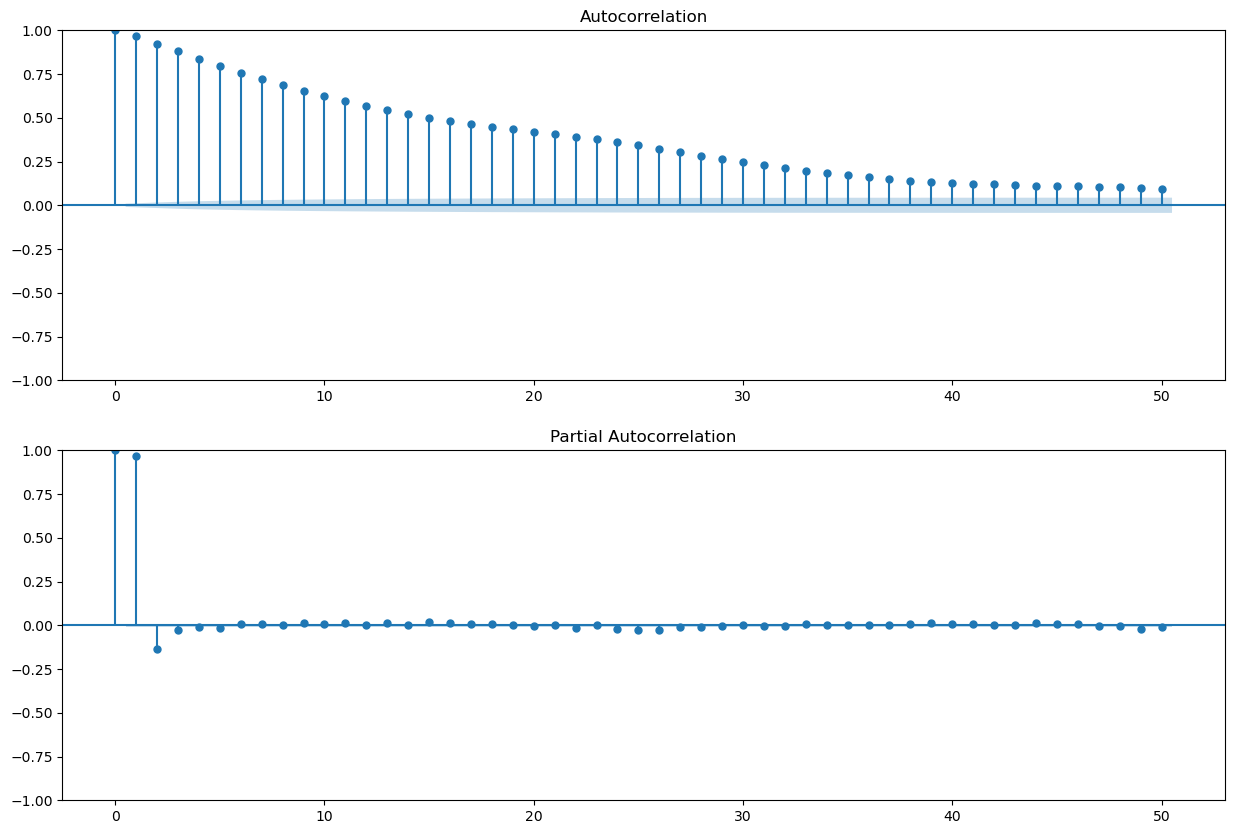

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(df["pm2.5_transformed"], lags=50, ax=axs[0])
plot_pacf(df["pm2.5_transformed"], lags=50, ax=axs[1])
plt.show()

Quel modèle comptez vous choisir ? 

> decay progressif (*peut-etre un peu lent*) du ACF / cut clair du PACF à 2 -> AR(2) ou AR(1)

Séparez votre jeu de données entre ensemble d'apprentissage et ensemble de test (80, 20)

**Gardez la même random seed pour pouvoir comparer les résultats entre vous !**

In [15]:
from sklearn.model_selection import train_test_split

X, y = df.drop(columns=["pm2.5", "pm2.5_transformed"]), df["pm2.5_transformed"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

Performez une grid search CV en testant différents hyperparamètres sur votre modèle. 

- Attention au choix de votre schéma de CV.

- Vous pouvez utiliser la mae comme méthode de scoring de votre GridSearch

- Vous pouvez créer un modèle `sklearn`compatible avec cette logique (je ne garantis pas que ce soit le meilleur modèle ci-dessous....) 
  
> pour pouvoir utiliser la tuyauterie sklearn (cross validation / pipelines etc ...) les prédicteurs que l'on utilise doivent entre autres implémenter des méthodes fit et transform

> je vous  ai donné un exemple de comment transformer un modèle statsmodel en modèle compatible avec sklearn **c'est une technique qui peut être utile à connaître**


> pour simplifier la suite je vais simplement prendre un modèle et faire la cv "à la main"

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.base import BaseEstimator, RegressorMixin

class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1,1,1), seasonal_order=(1,1,1,24)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model_ = None
        self.results_ = None

    def fit(self, X, y=None):
        # SARIMAX attend une série 1D
        self.model_ = SARIMAX(X, order=self.order, seasonal_order=self.seasonal_order)
        self.results_ = self.model_.fit(disp=False)
        return self

    def predict(self, X):
        # X n'est pas utilisé, on prédit sur la longueur de X
        n_steps = len(X)
        forecast = self.results_.get_forecast(steps=n_steps).predicted_mean
        return forecast


> D'près les plots, c'est sûrement un processus AR(2)pour "mailler" différents hyperparamètres possibles nous allons tester les modèles : 
- AR(1)
- AR(2)
- ARMA(1, 1)
- ARMA(2, 1)

et voir lequel a les meilleurs résultats

In [26]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

orders = [(2,0,0), (1,0,0), (2,0,1), (2,0,2)]
y_train.index = pd.to_datetime(y_train.index)
y_train = y_train.asfreq("h")

best_score = np.inf
best_order = None

for order in orders:
    scores = []
    tscv = TimeSeriesSplit(n_splits=4)

    for train_idx, val_idx in tscv.split(y_train):
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[val_idx]

        model = ARIMA(y_tr, order=order, freq="h").fit()
        preds = model.forecast(steps=len(y_val))
        scores.append(mean_squared_error(y_val, preds))

    score = np.mean(scores)

    if score < best_score:
        best_score = score
        best_order = order

print("Best order:", best_order)


/tmp/ipykernel_21941/3895577500.py:8: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/basile/.conda/envs/base_ds/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/basile/.conda/envs/base_ds/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Best order: (1, 0, 0)


Quel est le meilleur modèle obtenu ? Quel est son score ? 

In [18]:
print("Best order:", best_order)
print(f"Best score: {best_score:.2f}")

Best order: (1, 0, 0)
Best score: 3.68


> Le meilleur est donc AR(1) avec une MSE de 3.68

Tracez les prédictions du modèle sur l'ensemble d'entraînement.

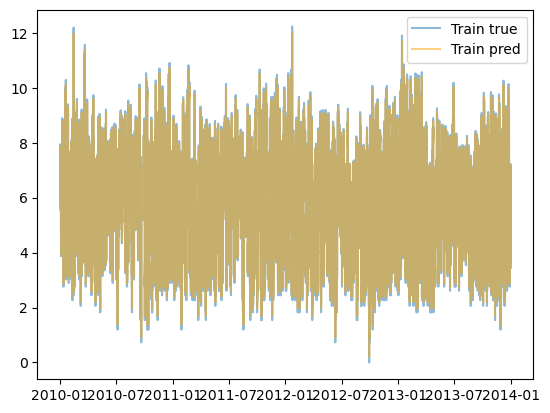

In [19]:
best_model = ARIMA(y_train, order=best_order).fit()

y_pred_train = best_model.predict(
    start=y_train.index[0],
    end=y_train.index[-1]
)

plt.plot(y_train.index, y_train, label="Train true", alpha=0.5)
plt.plot(y_train.index, y_pred_train, label="Train pred", color="orange", alpha=0.5)

plt.legend()
plt.show()


Diagnostiquez les résidus sur l'ensemble d'entraînement ? Voyez vous une structure ? 

> il y a des pics qui semblent régulier, globalement les résidus semblent hétéroscégastiques

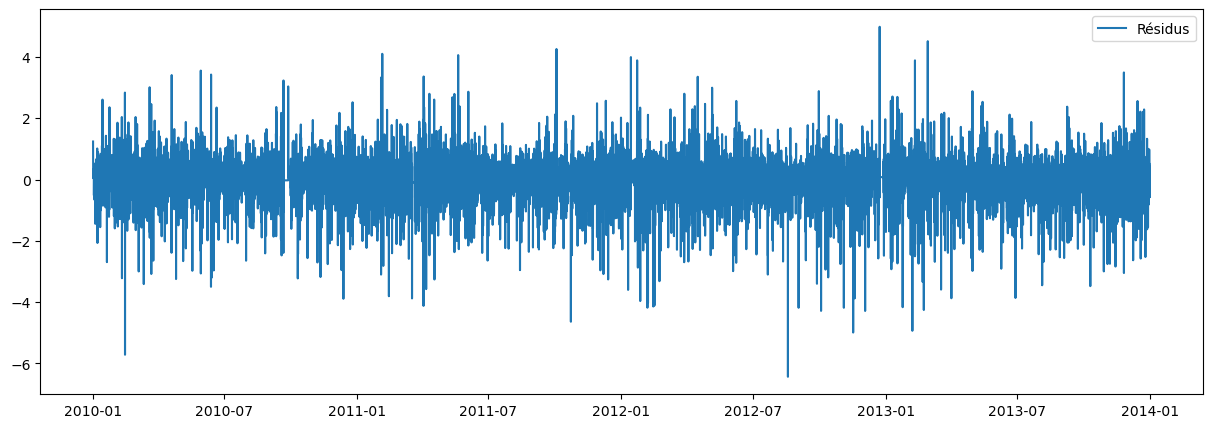

In [20]:

residus = y_train - y_pred_train
plt.figure(figsize=(15, 5))
plt.plot(residus, label="Résidus")
plt.legend()
plt.show()

Ils sont centrés (moyenne = 0) et la variance peu ou prou constante même si des pics semlent revenir régulièrement.

In [21]:
print(f"Mean residual: {residus.mean():.2f}")
print(f"Std residual: {residus.std():.2f}")

Mean residual: -0.00
Std residual: 0.49


Bien que l'autocorrélation ne soit pas immense, on voit qu'elle a un aspect saisonnier, ce qui confirme notre remarque précédente.

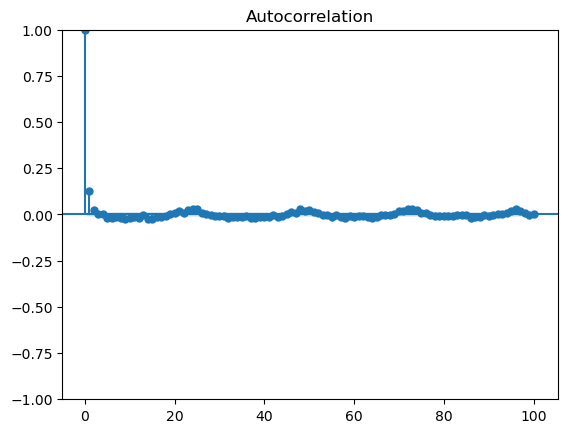

In [22]:
plot_acf(residus, lags=100)
plt.show()

Encore une confirmation ...

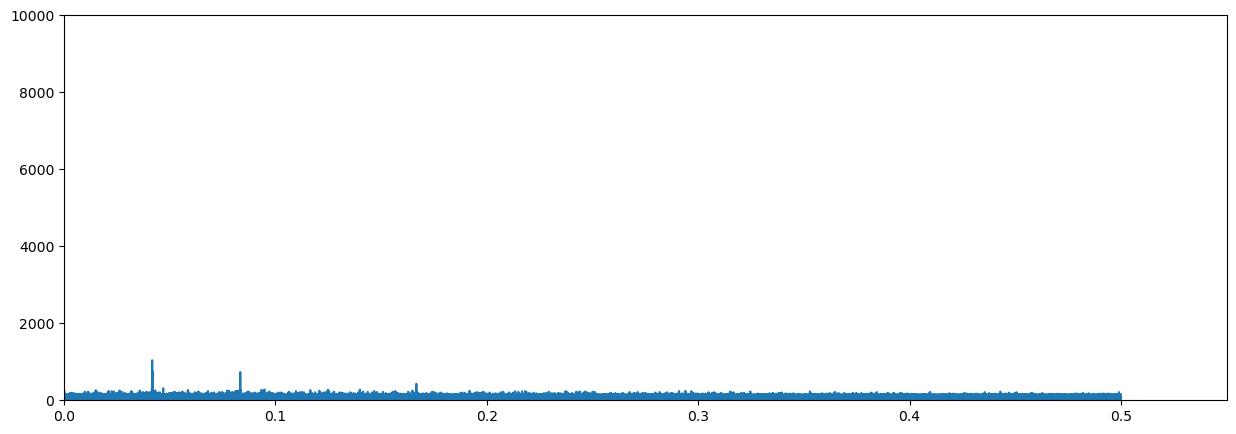

In [23]:
signal = residus

# fft 
fft_values = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(fft_values))
magnitude = np.abs(fft_values)

# plot interactif
import plotly
plt.figure(figsize=(15, 5))
plt.plot(frequencies, magnitude)
plt.xlim(0)
plt.ylim(0, 10000)
plt.show();

> on pourrait tenter d'améliorer le modèle avec un SARIMA / SARIMAX mais nous alllons continuer avec un Elasticnet

### 3. Modélisation multivariée

Vous pouvez reprendre la df complète et tenter de modéliser `pm2.5_transformed` avec les autres variables. 

Comparez les performances d'une régression linéaire multivariée avec un ElasticNet dont vous aurez grid-searché les meilleurs hyperparamètres. 

*En fin de séance ou chez vous selon le temps* : essayer d'améliorer votre score sur l'ensemble d'entraînement en créant de nouvelles features ou en testant de nouveaux modèles : attention à l'overfitting ! 

**Que le meilleur gagne !**

### Une réponse possible

In [28]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import numpy as np

# Target et features
y = df["pm2.5_transformed"].astype(float)
X = df.drop(columns=["pm2.5_transformed", "pm2.5"])

# Holdout temporel d'un an
holdout_split = 24 * 365 
X_train, X_test = X.iloc[:-holdout_split], X.iloc[-holdout_split:]
y_train, y_test = y.iloc[:-holdout_split], y.iloc[-holdout_split:]

tss = TimeSeriesSplit(n_splits=5)


In [30]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet

# Séparer les colonnes
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
    ]
)

enet_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", ElasticNet(max_iter=5000))
])

param_grid = {
    "model__alpha": np.logspace(-3, 1, 5),
    "model__l1_ratio": [0.1, 0.5, 0.9],
}

gs = GridSearchCV(
    enet_pipe,
    param_grid,
    cv=tss,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2,
)

gs

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         Index(['cbwd', 'season'], dtype='object'))])),
                                       ('model', ElasticNet(max_iter=5000))]),
             n_jobs=-1,
             param_grid={'model__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                         'model__l1_ratio': [0.1, 0.5, 0.9]},
             scoring='neg_mean_absolute_error', verbose=2)

In [31]:

gs.fit(X_train, y_train)
best_enet = gs.best_estimator_

y_pred_enet = best_enet.predict(X_test)

enet_r2 = r2_score(y_test, y_pred_enet)
enet_mae = mean_absolute_error(y_test, y_pred_enet)
enet_rmse = root_mean_squared_error(y_test, y_pred_enet)

print("\n=== ElasticNet (optimisé) ===")
print(f"R2   : {enet_r2:.3f}")
print(f"MAE  : {enet_mae:.3f}")
print(f"RMSE : {enet_rmse:.3f}")

print("\nMeilleurs hyperparamètres ElasticNet :", gs.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END ............model__alpha=0.001, model__l1_ratio=0.1; total time=   0.1s
[CV] END ............model__alpha=0.001, model__l1_ratio=0.1; total time=   0.2s
[CV] END ............model__alpha=0.001, model__l1_ratio=0.1; total time=   0.2s
[CV] END ............model__alpha=0.001, model__l1_ratio=0.5; total time=   0.2s
[CV] END ............model__alpha=0.001, model__l1_ratio=0.5; total time=   0.2s
[CV] END ............model__alpha=0.001, model__l1_ratio=0.1; total time=   0.3s
[CV] END ............model__alpha=0.001, model__l1_ratio=0.1; total time=   0.3s
[CV] END ............model__alpha=0.001, model__l1_ratio=0.5; total time=   0.2s
[CV] END ............model__alpha=0.001, model__l1_ratio=0.9; total time=   0.1s
[CV] END ............model__alpha=0.001, model__l1_ratio=0.5; total time=   0.3s
[CV] END ............model__alpha=0.001, model__l1_ratio=0.9; total time=   0.2s
[CV] END ............model__alpha=0.001, model__

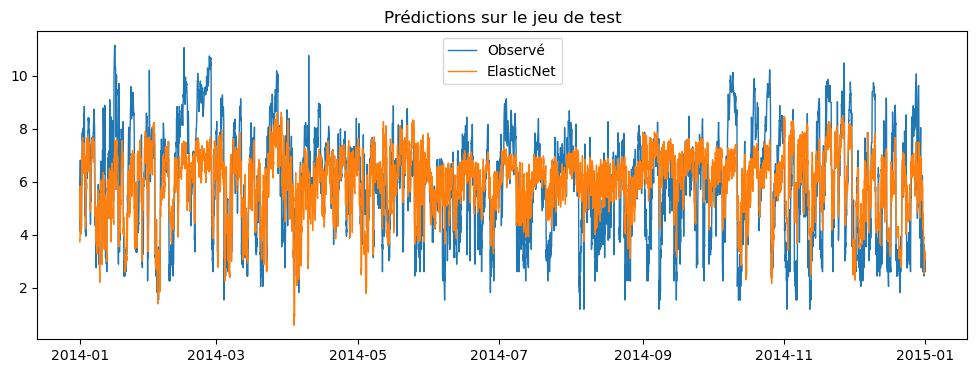

In [32]:
plt.figure(figsize=(12, 4))
plt.plot(y_test.index, y_test, label="Observé", lw=1)
plt.plot(y_test.index, y_pred_enet, label="ElasticNet", lw=1)
plt.legend()
plt.title("Prédictions sur le jeu de test")
plt.show()

## Un peu d'amélioration en construisant des features temporelles

In [45]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
import holidays

class HolidayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, country="CN"): # china
        self.country = country

    def fit(self, X, y=None):
        self.holidays_ = holidays.country_holidays(self.country)
        return self

    def transform(self, X):
        idx = X.index
        return np.array([[1 if d.date() in self.holidays_ else 0] for d in idx])

class CyclicalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, freq_map=None):
        self.freq_map = freq_map or {
            "hour": 24,
            "dayofweek": 7,
            "month": 12,
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        idx = X.index

        features = []

        for name, period in self.freq_map.items():
            if name == "hour":
                values = idx.hour
            elif name == "dayofweek":
                values = idx.dayofweek
            elif name == "month":
                values = idx.month - 1

            features.append(np.sin(2 * np.pi * values / period))
            features.append(np.cos(2 * np.pi * values / period))

        return np.column_stack(features)
    
cyclical_pipe = Pipeline([
    ("features", ColumnTransformer(
        transformers=[
            # Features temporelles
            ("cyclical", CyclicalFeatures(), X.columns),
            ("holidays", HolidayTransformer(country="CN"), X.columns),

            # Exogènes
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ],
        remainder="drop"
    )),
    ("model", ElasticNet(max_iter=5000))
])


param_grid_cyclical = {
    "model__alpha": np.logspace(-5, 1, 5),
    "model__l1_ratio": [0.1, 0.5, 0.9],
}

gs_cyclical = GridSearchCV(
    cyclical_pipe,
    param_grid_cyclical,
    cv=tss,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
)

gs_cyclical


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('features',
                                        ColumnTransformer(transformers=[('cyclical',
                                                                         CyclicalFeatures(freq_map={'dayofweek': 7,
                                                                                                    'hour': 24,
                                                                                                    'month': 12}),
                                                                         Index(['DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir', 'dayofweek', 'hour',
       'month', 'season'],
      dtype='object')),
                                                                        ('holidays',
                                                                         Ho...
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         Index(['cbwd', 'season'], dtype='object'))])),
                                       ('model', ElasticNet(max_iter=5000))]),
             n_jobs=-1,
             param_grid={'model__alpha': array([1.00000000e-05, 3.16227766e-04, 1.00000000e-02, 3.16227766e-01,
       1.00000000e+01]),
                         'model__l1_ratio': [0.1, 0.5, 0.9]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=2)

In [46]:

gs_cyclical.fit(X_train, y_train)

best_cyclical = gs_cyclical.best_estimator_

print("Meilleurs hyperparamètres :", gs_cyclical.best_params_)
print("Meilleur score CV (MAE) :", -gs_cyclical.best_score_)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END ............model__alpha=1e-05, model__l1_ratio=0.1; total time=   0.7s
[CV] END ............model__alpha=1e-05, model__l1_ratio=0.1; total time=   1.1s
[CV] END ............model__alpha=1e-05, model__l1_ratio=0.5; total time=   1.2s
[CV] END ............model__alpha=1e-05, model__l1_ratio=0.5; total time=   1.0s
[CV] END ............model__alpha=1e-05, model__l1_ratio=0.5; total time=   1.0s
[CV] END ............model__alpha=1e-05, model__l1_ratio=0.1; total time=   1.1s
[CV] END ............model__alpha=1e-05, model__l1_ratio=0.1; total time=   1.5s
[CV] END ............model__alpha=1e-05, model__l1_ratio=0.1; total time=   1.6s
[CV] END ............model__alpha=1e-05, model__l1_ratio=0.5; total time=   1.3s
[CV] END ............model__alpha=1e-05, model__l1_ratio=0.9; total time=   1.0s
[CV] END ............model__alpha=1e-05, model__l1_ratio=0.9; total time=   1.3s
[CV] END ............model__alpha=1e-05, model__

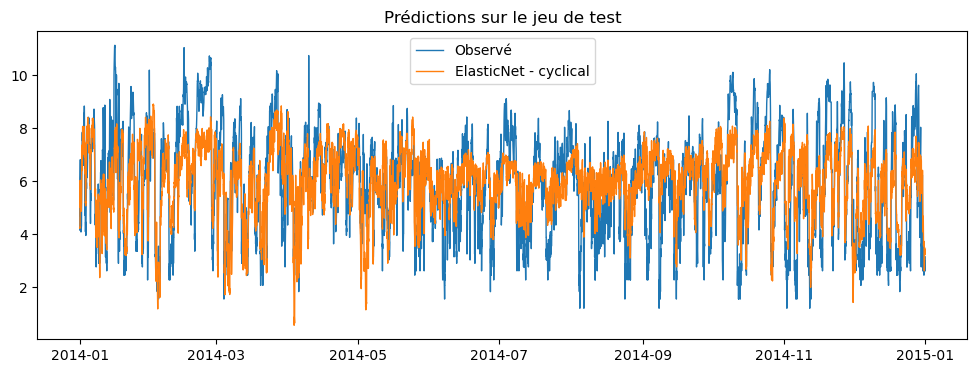

In [47]:
plt.figure(figsize=(12, 4))
plt.plot(y_test.index, y_test, label="Observé", lw=1)
plt.plot(y_test.index, best_cyclical.predict(X_test), label="ElasticNet - cyclical", lw=1)
plt.legend()
plt.title("Prédictions sur le jeu de test")
plt.show()